In [1]:
import torch
torch.cuda.empty_cache()

import hr_dv2.transform as tr
from hr_dv2.utils import *
from hr_dv2 import HighResDV2
from hr_dv2.high_res import torch_pca

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from featup.util import norm, unnorm
use_norm = True

In [2]:
def load_img(path: str, size: int=224) -> tuple[torch.Tensor, np.ndarray]:
    _img = Image.open(path)
    _h, _w = _img.height, _img.width
    t = tr.get_input_transform(size, size)

    img_tensor, img = tr.load_image(path, t)
    img_arr = np.array(img)

    img_tensor.to(torch.float16)
    return img_tensor, img_arr

def set_transforms(net: torch.nn.Module, stride: int=4):
    shift_dists = [i for i in range(1, stride - 1)]
    fwd_shift, inv_shift = tr.get_shift_transforms(shift_dists, 'Moore')
    fwd_flip, inv_flip = tr.get_flip_transforms()
    fwd, inv = tr.combine_transforms(fwd_shift, fwd_flip, inv_shift, inv_flip)
    net.set_transforms(fwd, inv)


In [3]:
IMG_SIZE = 384

In [4]:

out = []
models = ["vit_vits16", "deit_vits16", "dino_vits16", "dino_vits8", "dinov2_vits14_reg"]
for i in range(1, 3):
    fname = f"fig_data/{i}.jpg"
    for model in models:
        print(f"{i}: {model}")
        torch.cuda.empty_cache()
        net = HighResDV2(model, 4, pca_dim=128, dtype=torch.float16)
        net.interpolation_mode = 'nearest-exact'
        net.cuda()
        net.eval()

        set_transforms(net, 4)

        size = 224 #384 if model != "dinov2_vits14_reg" else 378
        img_tensor, img_arr = load_img(fname, size)
        img_tensor = img_tensor.cuda()

        feats_attn_tensor = net.forward(img_tensor, attn_choice='none')
        pcaed = torch_pca(feats_attn_tensor.squeeze(0), 3, max_samples=50000)
        pcaed = tr.to_numpy(pcaed)
        rescaled = rescale_pca(pcaed)
        out.append(rescaled)

1: vit_vits16
1: deit_vits16
1: dino_vits16


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


1: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


1: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


2: vit_vits16
2: deit_vits16
2: dino_vits16


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


2: dino_vits8


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


2: dinov2_vits14_reg


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main


0 ['ViT-S 16', 'DEiT-S 16', 'DINO-S 16', 'DINO-S 8', 'Dv2-S 16']
1 ['ViT-S 16', 'DEiT-S 16', 'DINO-S 16', 'DINO-S 8', 'Dv2-S 16']
2 ['ViT-S 16', 'DEiT-S 16', 'DINO-S 16', 'DINO-S 8', 'Dv2-S 16']
3 ['ViT-S 16', 'DEiT-S 16', 'DINO-S 16', 'DINO-S 8', 'Dv2-S 16']
4 ['ViT-S 16', 'DEiT-S 16', 'DINO-S 16', 'DINO-S 8', 'Dv2-S 16']


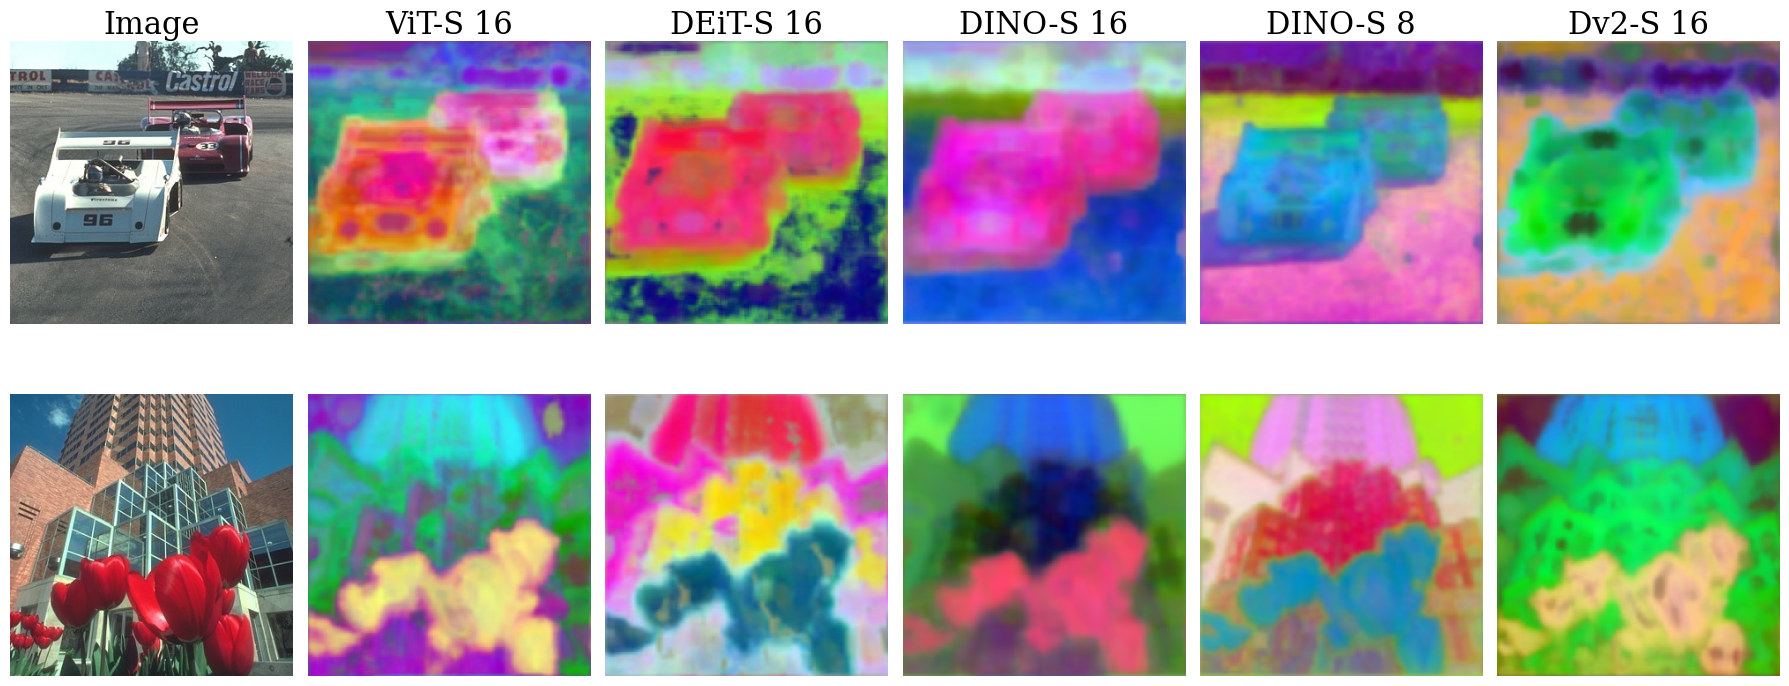

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=len(models) + 1)
plt.rcParams["font.family"] = "serif"

model_names = ["ViT-S 16", "DEiT-S 16", "DINO-S 16", "DINO-S 8", "Dv2-S 16"]

fig.set_size_inches(18, 8)
i = 0
font_size = 22
for row in range(2):
    img = Image.open(f"fig_data/{row + 1}.jpg")
    axs[row, 0].imshow(img)
    if row == 0:
        axs[row, 0].set_title("Image", fontsize=font_size)
    axs[row, 0].set_axis_off()

    for column in range(0, len(models)):
        ax = axs[row, column + 1]
        if row == 0:
            print(column, model_names )
            ax.set_title(model_names[column], fontsize=font_size)

        model = models[column]
        size = 224 # if model != "dinov2_vits14_reg" else 378

        data = out[i]
        img = data.reshape((size, size, 3))
        ax.imshow(img)
        ax.set_axis_off()
        i += 1
plt.tight_layout()
plt.savefig('out/model_comparison.png')

In [17]:
method_out = []
resize_methods = ["nearest-exact", "bilinear", "nearest-exact", "nearest-exact", "featup"]
strides = [8, 8, 4, 4, "foo"]
for i in range(3, 5):
    fname = f"fig_data/{i}.jpg"
    for j, resize in enumerate(resize_methods):
        print(f"{i}: {resize}")
        torch.cuda.empty_cache()
        if j == 4:
            net = torch.hub.load("mhamilton723/FeatUp", 'dino16', use_norm=use_norm)
        else:
            net = HighResDV2("dino_vits8", strides[j], pca_dim=128, dtype=torch.float16)
            net.interpolation_mode = resize
        net.cuda()
        net.eval()


        if j == 3:
            set_transforms(net, 4)

        size = 224 #if j == 4 else 256
        img_tensor, img_arr = load_img(fname, size)
        img_tensor = img_tensor.cuda()

        if j < 4:
            feats_attn_tensor = net.forward(img_tensor, attn_choice='none')
        else:
            feats_attn_tensor = net(img_tensor.unsqueeze(0))
        pcaed = torch_pca(feats_attn_tensor.squeeze(0), 3, max_samples=50000)
        pcaed = tr.to_numpy(pcaed)
        rescaled = rescale_pca(pcaed)
        method_out.append(rescaled)

3: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


3: bilinear


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


3: bilinear


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


3: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


3: featup


Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: bilinear


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: bilinear


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: nearest-exact


Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


4: featup


Using cache found in /home/ronan/.cache/torch/hub/mhamilton723_FeatUp_main
Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dino_main


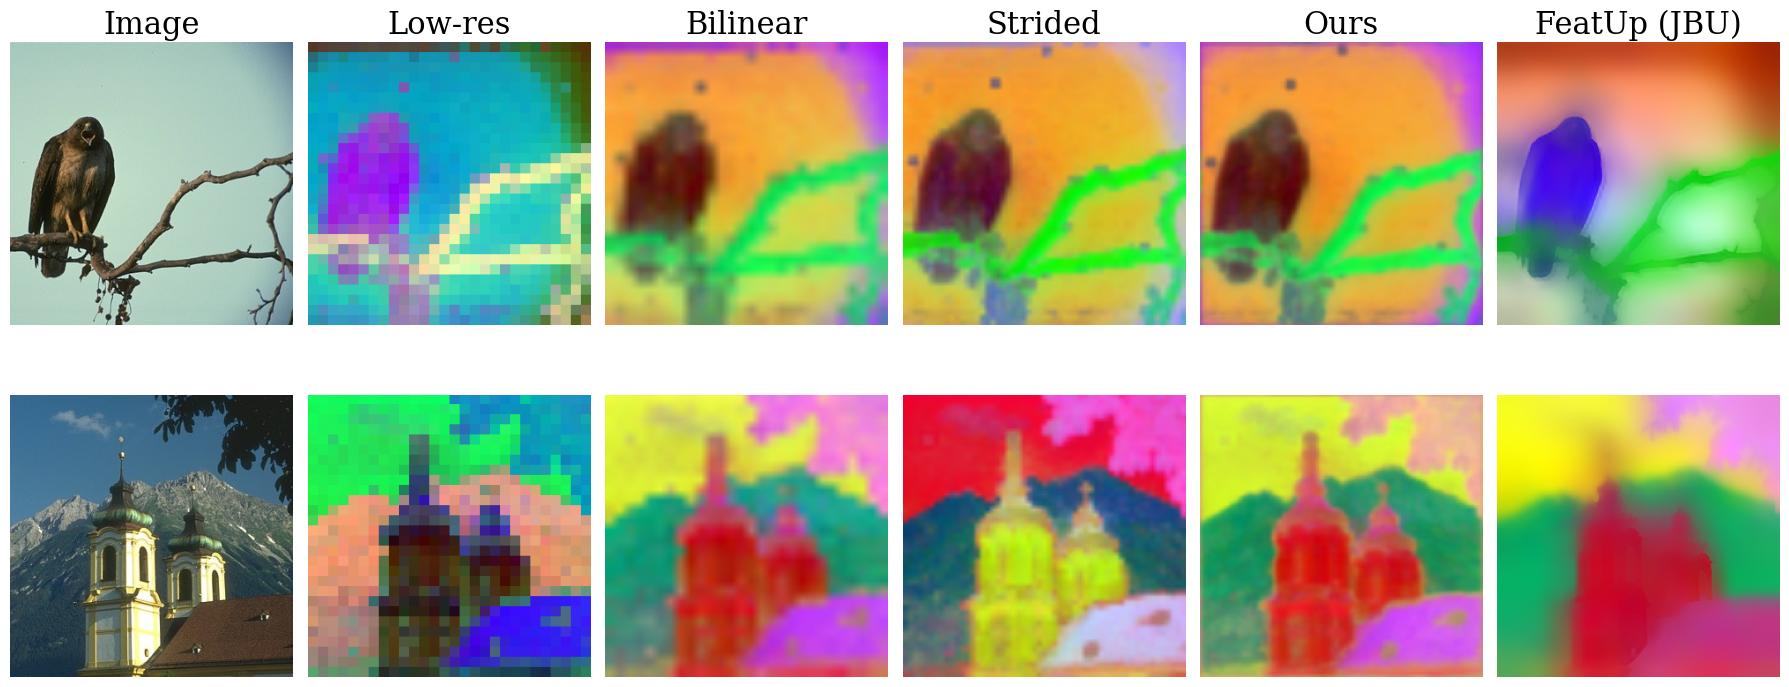

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=len(resize_methods) + 1)
plt.rcParams["font.family"] = "serif"

model_names = ["Low-res", "Bilinear", "Strided", "Ours", "FeatUp (JBU)"]

fig.set_size_inches(18, 8)
i = 0
font_size = 22
for row in range(2):
    img = Image.open(f"fig_data/{row + 3}.jpg")
    axs[row, 0].imshow(img)
    if row == 0:
        axs[row, 0].set_title("Image", fontsize=font_size)
    axs[row, 0].set_axis_off()

    for column in range(1, len(model_names) + 1):
        ax = axs[row, column]
        if row == 0:
            ax.set_title(model_names[column - 1], fontsize=font_size)

        size = 224 #if column == 5 else 256 #'#384 if model != "dinov2_vits14_reg" else 378

        data = method_out[i]
        img = data.reshape((size, size, 3))
        ax.imshow(img)
        ax.set_axis_off()
        i += 1
plt.tight_layout()
plt.savefig('out/method_comparison.png')